In [1]:
#from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
from rdmg import rdm_ginibre
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_paulis():
    Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
    aux = 0
    for i in range(0,d,3):
        Paulis[i+aux] = torch.tensor([[0, 1], [1, 0]])        
        Paulis[i+1+aux] = torch.tensor([[0, -1j], [1j, 0]])
        Paulis[i+2+aux] = torch.tensor([[1, 0], [0, -1]])
        aux += 2
    return Paulis

def init_state_rsvg(n_qb):
    d = 2**n_qb
    target_vector = rsvg(d)
    target_op = np.outer(target_vector.conj(), target_vector)
    target_op = torch.tensor(target_op)
    return target_vector, target_op

def init_state_rdm_ginibre(n_qb):
    d = 2**n_qb
    rho = rdm_ginibre(d)
    print(np.trace(np.dot(rho,rho)))
    target_op = torch.tensor(rho)
    return target_op

def init_state_exp_val(d):
    rrho = rdm_ginibre(4)
    Paulis = gen_paulis(d)
    target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
    target_vector = Variable(torch.tensor(target_vector ))
    return target_vector

def get_device(n_qubit):
    device = qml.device('qiskit.aer', wires=n_qubit, backend='qasm_simulator')
    return device

def random_params(n):
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    return params

def fidelidade(circuit, params, target_op):
    return circuit(params, M=target_op).item()

def cost(circuit, params, alpha):
    L = (1-(circuit(params, M=alpha)))**2
    return L

def train(epocas, circuit, params, alpha):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(circuit, params, alpha)
    best_params = 1*params
    f=[]
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(circuit, params, alpha)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
        f.append(fidelidade(circuit, best_params, alpha))
    return best_params, f

# Iniciando o estado aleatório com rdm_ginibre

(0.5131876764866805+0j)
tensor([[ 0.3763+0.0000j, -0.1576+0.0857j,  0.1935+0.1016j,  0.1088+0.0294j],
        [-0.1576-0.0857j,  0.3557+0.0000j, -0.0411-0.0351j,  0.0589-0.0201j],
        [ 0.1935-0.1016j, -0.0411+0.0351j,  0.1529+0.0000j,  0.0681-0.0138j],
        [ 0.1088-0.0294j,  0.0589+0.0201j,  0.0681+0.0138j,  0.1152+0.0000j]],
       dtype=torch.complex128)


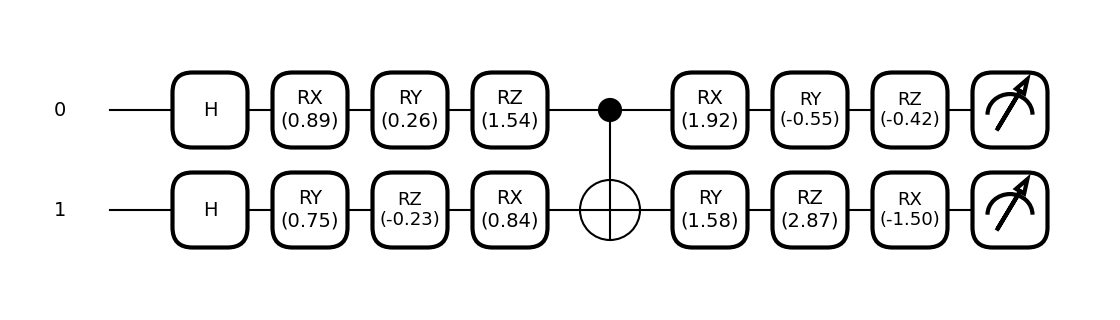

In [3]:
n_qubits = 2
n = 6*n_qubits
alpha = init_state_rdm_ginibre(n_qubits)
print(alpha)
params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.45572290605358595
1 0.35280281486808523
2 0.2622301014151547
3 0.23311735001321376
4 0.20393373468321666
5 0.1900186659925191
6 0.1730024751815223
7 0.1655234504770978
8 0.15883526459377448
9 0.15938161300429313
10 0.15886798578273556
11 0.15325682324987622
12 0.14562313195395538
13 0.1417444104205672
14 0.13858948964213258
15 0.13208061306514435
16 0.13147793604677507
17 0.1303052480486759
18 0.13336014587770076
19 0.13328963511228184
20 0.13539561805435824
21 0.13767409856959406
22 0.1346867165147189
23 0.13208205575988521
24 0.13418407193631335
25 0.1288346063034548
26 0.12943262934297703
27 0.1281239828527748
28 0.1278794580938054
29 0.12528091737186203
30 0.12336051501005904
31 0.12408171829235487
32 0.12473681229531725
33 0.12497154851757766
34 0.12541765584556347
35 0.12428517048935615
36 0.1270042000401917
37 0.12618253376005195
38 0.12600770445555143
39 0.12463115155662614
40 0.1265002047425728
41 0.12445810091094435
42 0.12535605418929763
43 0.1253936310448063
44 0.123841

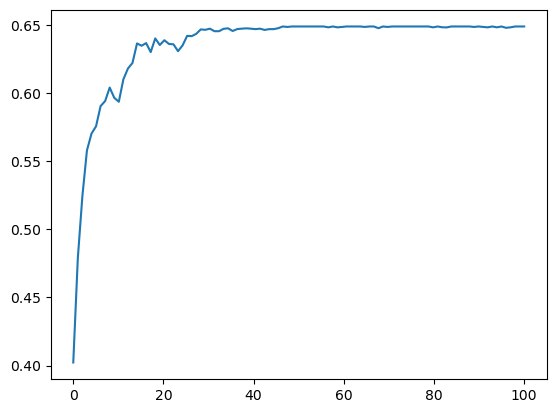

In [4]:
best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()


In [6]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.6484841748615455


In [5]:
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return  qml.probs(wires=[0,1])
counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
#print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

tensor([0.5234, 0.2725, 0.1670, 0.0371], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)
[[ 0.37626711+0.j         -0.15759332+0.08571461j  0.19346076+0.10156826j
   0.10877248+0.02942129j]
 [-0.15759332-0.08571461j  0.35566765+0.j         -0.04106124-0.03506653j
   0.0588897 -0.02006553j]
 [ 0.19346076-0.10156826j -0.04106124+0.03506653j  0.15286316+0.j
   0.06808625-0.01383325j]
 [ 0.10877248-0.02942129j  0.0588897 +0.02006553j  0.06808625+0.01383325j
   0.11520208+0.j        ]]
------------------------
[0.72348981 0.52197791 0.40864678 0.19263794]
[[0.5234375  0.3776457  0.29565178 0.13937158]
 [0.3776457  0.27246094 0.21330459 0.10055275]
 [0.29565178 0.21330459 0.16699219 0.07872087]
 [0.13937158 0.10055275 0.07872087 0.03710937]]


# Iniciando o estado aleatório com rsvg

torch.Size([132])
0
1
2
3
4
5
6
7
8
9


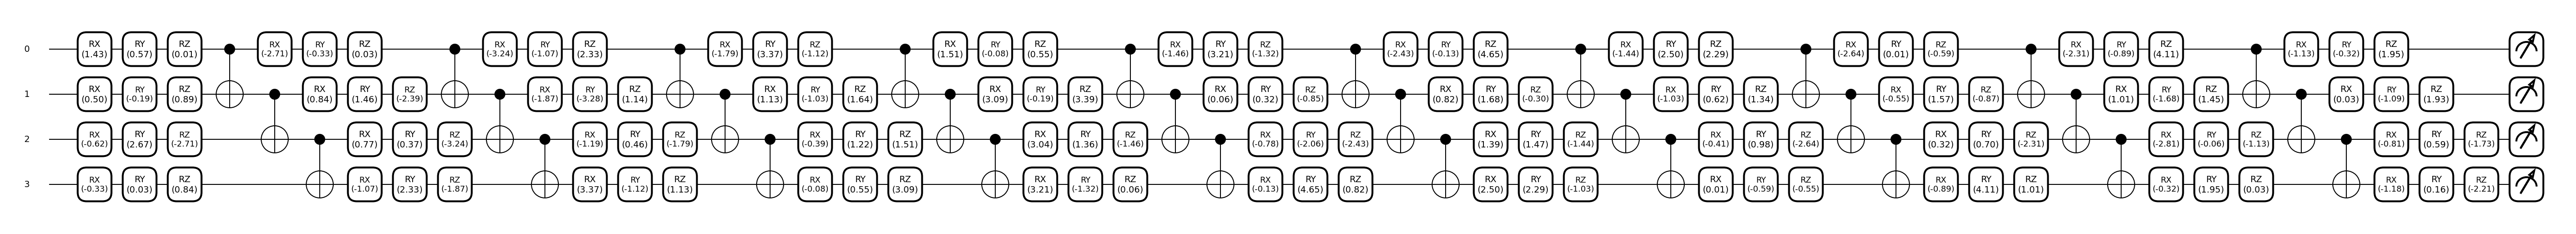

In [6]:
from tools import *
n_qubits = 4
depht = 10
#n = 3*n_qubits+depht*n_qubits*3
n = 3*n_qubits*(1+depht)
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
print(np.shape(params))
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    #n_qubits = 5
    #depht = 10
    #n = 6*n_qubits
    w = []

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        w.append(j)
        aux+=2
    
    for z in range(depht):
        print(z)
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i,i+1])
        for j in range(n_qubits):
            qml.RX(params[j+aux], wires=j)
            qml.RY(params[j+1+aux], wires=j)
            qml.RZ(params[j+2+aux], wires=j)
            aux+=2
        #for j in range(n_qubits):
        #    qml.RX(params[j+aux], wires=j)
        #    qml.RY(params[j+1+aux], wires=j)
        #    qml.RZ(params[j+2+aux], wires=j)
        #    aux+=2
        #for i in range(n_qubits-1):
        #    qml.CNOT(wires=[i,i+1])
        #for j in range(n_qubits):
        #    qml.RX(params[j+aux], wires=j)
        #    qml.RY(params[j+1+aux], wires=j)
        #    qml.RZ(params[j+2+aux], wires=j)
        #    aux+=2
    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0 0.9805641174316406
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
1 0.30984878540039085
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
2 0.12291049957275421
0
1
2
3
4
5
6
7
8
9


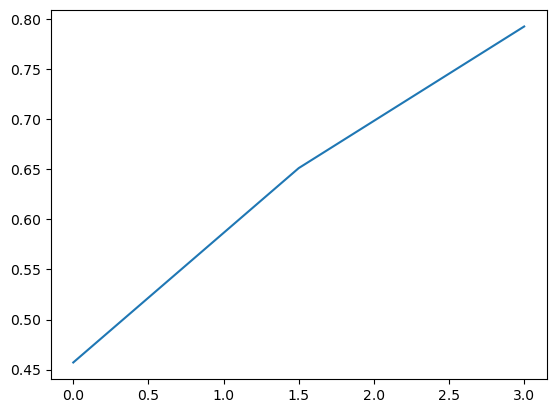

In [7]:
best_params, f = train(3, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

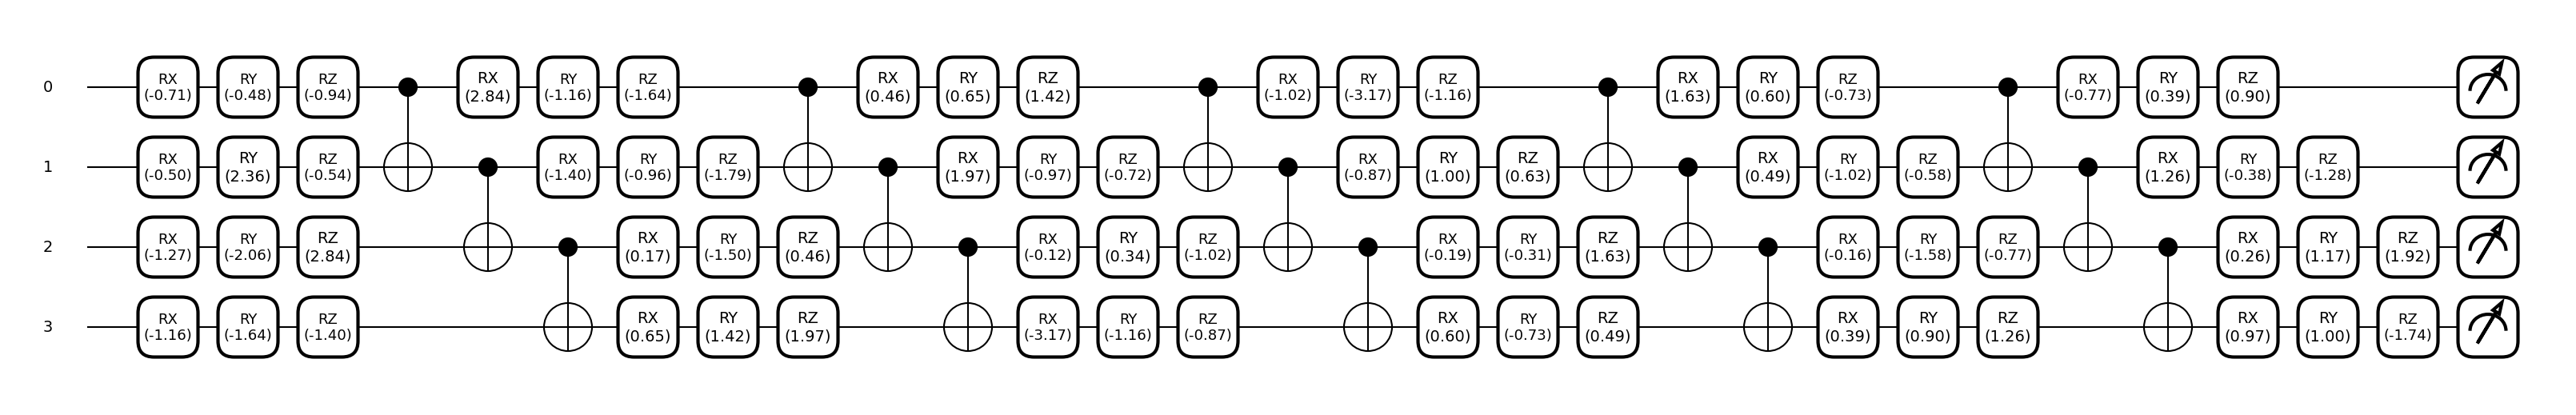

In [5]:
from tools import *
n_qubits = 4
depht = 5
#n = 3*n_qubits+depht*n_qubits*3
n_params = 3*n_qubits*(1+depht)
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
#print(np.shape(params))
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    #n_qubits = 5
    #depht = 10
    #n = 6*n_qubits
    w = []

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        w.append(j)
        aux+=2
    
    for z in range(depht):
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i,i+1])
        for j in range(n_qubits):
            qml.RX(params[j+aux], wires=j)
            qml.RY(params[j+1+aux], wires=j)
            qml.RZ(params[j+2+aux], wires=j)
            aux+=2
        #for j in range(n_qubits):
        #    qml.RX(params[j+aux], wires=j)
        #    qml.RY(params[j+1+aux], wires=j)
        #    qml.RZ(params[j+2+aux], wires=j)
        #    aux+=2
        #for i in range(n_qubits-1):
        #    qml.CNOT(wires=[i,i+1])
        #for j in range(n_qubits):
        #    qml.RX(params[j+aux], wires=j)
        #    qml.RY(params[j+1+aux], wires=j)
        #    qml.RZ(params[j+2+aux], wires=j)
        #    aux+=2
    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.98443603515625
1 0.7622108459472656
2 0.46596622467041016
3 0.3001413345336914
4 0.15106582641601562
5 0.11154556274414062
6 0.0753030776977539
7 0.0726470947265625
8 0.058182716369628906
9 0.06798648834228516
10 0.0700387954711914
11 0.052666664123535156
12 0.050889015197753906
13 0.031937599182128906
14 0.019501686096191406
15 0.024109840393066406
16 0.016117095947265625
17 0.013278961181640625
18 0.0166168212890625
19 0.011539459228515625
20 0.012612342834472656
21 0.007218360900878906
22 0.005082130432128906
23 0.005364418029785156
24 0.006569862365722656
25 0.004029273986816406
26 0.005654335021972656
27 0.0025787353515625
28 0.0030984878540039062
29 0.0012359619140625
30 0.00152587890625
31 0.0012359619140625
32 0.0011682510375976562
33 0.0005960464477539062
34 0.001377105712890625
35 0.0012359619140625
36 0.0018463134765625
37 0.0010385513305664062
38 0.001102447509765625
39 0.0013055801391601562
40 0.001102447509765625
41 0.0009164810180664062
42 0.000644683837890625
43 0.0

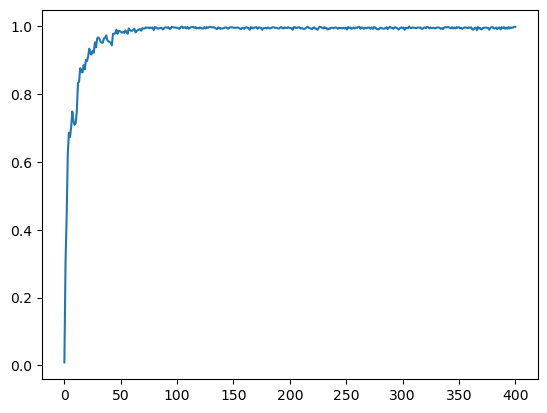

In [6]:
best_params, f = train(400, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [7]:
import pickle
with open('best_params.pkl', 'wb') as g:
    pickle.dump(best_params, g)

In [8]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.9990234375


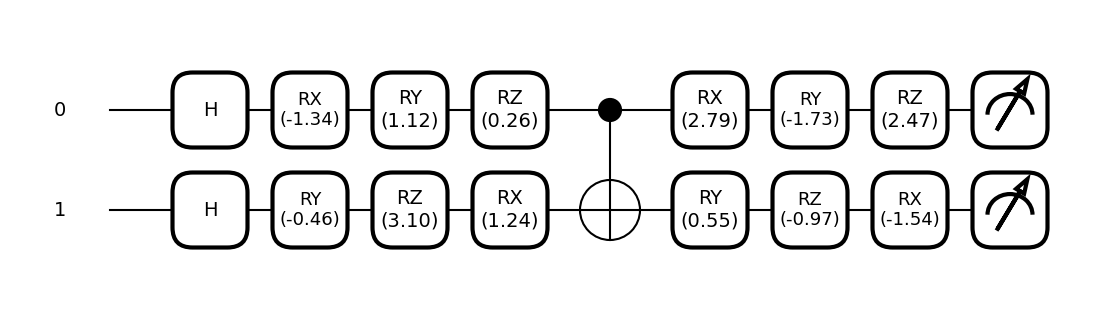

In [4]:
n_qubits = 2
n = 6*n_qubits
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.7004251480102539
1 0.46596622467041016
2 0.289536476135254
3 0.20092105865478527
4 0.08640384674072273
5 0.03552341461181645
6 0.021457672119140656
7 0.00807189941406252
8 0.004807472229003922
9 0.007053375244140644
10 0.008248329162597677
11 0.013962745666503932
12 0.016869544982910184
13 0.02088928222656253
14 0.018959999084472687
15 0.021457672119140656
16 0.01869201660156253
17 0.013732910156250026
18 0.014663696289062528
19 0.011962890625000024
20 0.009922027587890648
21 0.008426666259765646
22 0.00878906250000002
23 0.007385253906250019
24 0.009922027587890648
25 0.0065698623657226745
26 0.004943847656250016
27 0.004540443420410171
28 0.004807472229003922
29 0.0035486221313476697
30 0.0021066665649414167
31 0.0025787353515625113
32 0.001931190490722666
33 0.0025787353515625113
34 0.002017974853515635
35 0.0015258789062500087
36 0.0010385513305664134
37 0.000916481018066413
38 0.0007476806640625061
39 0.00034427642822266037
40 0.00034427642822266037
41 0.00034427642822266037
4

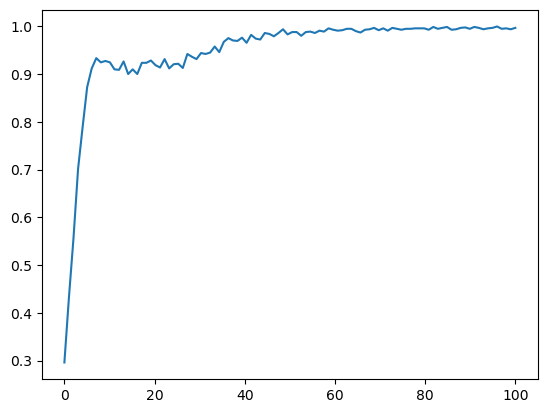

In [5]:
best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [11]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.9951171874999999


In [12]:
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return  qml.probs(wires=[0,1])
counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

tensor([0.1953, 0.0859, 0.4443, 0.2744], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)
[-0.10418639+0.44250651j -0.13166609-0.18125312j  0.04999019+0.65957495j
 -0.45022131-0.32079148j]
[[ 0.20666682+0.j         -0.06648787+0.07714721j  0.28665791-0.09083972j
  -0.09504539+0.23264797j]
 [-0.06648787-0.07714721j  0.05018865+0.j         -0.12613203-0.07778277j
   0.11742333-0.03936666j]
 [ 0.28665791+0.09083972j -0.12613203+0.07778277j  0.43753813+0.j
  -0.23409267+0.28091827j]
 [-0.09504539-0.23264797j  0.11742333+0.03936666j -0.23409267-0.28091827j
   0.3056064 +0.j        ]]
------------------------
[0.44194174 0.29315098 0.66658528 0.52384546]
[[0.1953125  0.12955566 0.29459186 0.23150917]
 [0.12955566 0.0859375  0.19541013 0.15356581]
 [0.29459186 0.19541013 0.44433594 0.34918767]
 [0.23150917 0.15356581 0.34918767 0.27441406]]


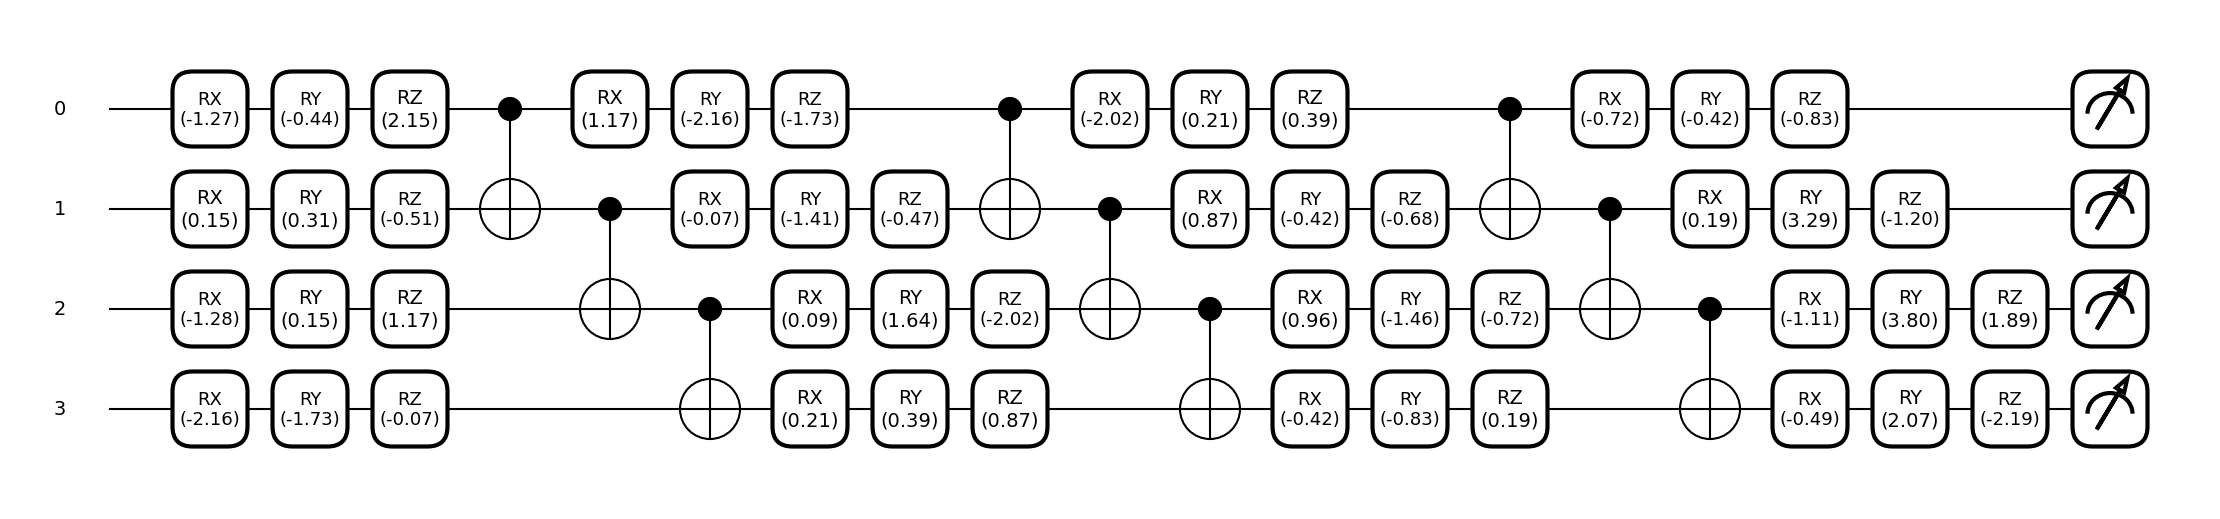

In [23]:
n_qubits = 4
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n+24)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    #n_qubits = 5
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
    #    qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()


0 0.9441614151000977
1 0.7862701416015627
2 0.6428155899047855
3 0.5876779556274417
4 0.4566802978515628
5 0.3120269775390629
6 0.22711181640625042
7 0.15106582641601596
8 0.16424655914306677
9 0.19397830963134804
10 0.18045902252197304
11 0.18212223052978554
12 0.16903018951416052
13 0.1326837539672855
14 0.10011291503906278
15 0.08412265777587917
16 0.0964393615722659
17 0.06952285766601586
18 0.05088901519775411
19 0.042057037353515805
20 0.031243324279785312
21 0.028542518615722805
22 0.03406620025634782
23 0.04165744781494159
24 0.027886390686035305
25 0.023208618164062635
26 0.02350711822509779
27 0.02261734008789076
28 0.017380714416504024
29 0.010514259338378998
30 0.0128326416015626
31 0.008248329162597738
32 0.006103515625000069
33 0.007724761962890703
34 0.005222320556640689
35 0.007724761962890703
36 0.005951881408691475
37 0.005802154541015693
38 0.00807189941406258
39 0.003785133361816461
40 0.005654335021972723
41 0.00508213043212897
42 0.004281044006347714
43 0.00480747

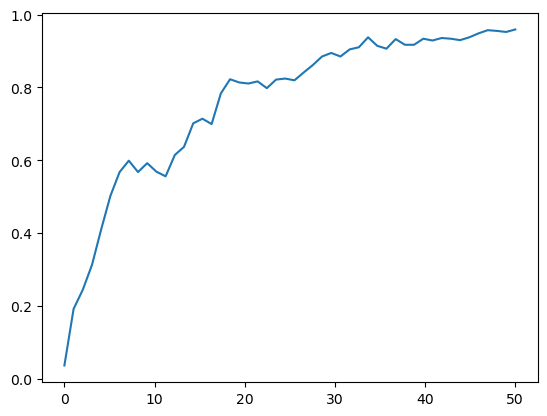

In [24]:
best_params, f = train(50, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [25]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.9628906249999996


In [6]:
n_qubits = 5
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    #n_qubits = 5
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    
    return  qml.probs(wires=w)

counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

IndexError: index 18 is out of bounds for dimension 0 with size 18